In [1]:
import cdsapi
import os
import ssl
import warnings
from pathlib import Path
from tqdm import tqdm

import warnings
import netCDF4
from netCDF4 import num2date
import zipfile
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
import rasterio as rio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds


from metadata import param_md
# Suppress all warnings
warnings.filterwarnings("ignore")

data_dir = Path(".data")


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [7]:
param_md


,count,name,units,Variable name in CDS,shortName,ParamId,an,fc
0,1,Lake cover,(0 - 1),lake_cover,cl,26,x,x
1,2,Lake depth,m,lake_depth,dl,228007,x,x
2,3,Low vegetation cover,(0 - 1),low_vegetation_cover,cvl,27,x,NaN
3,4,High vegetation cover,(0 - 1),high_vegetation_cover,cvh,28,x,NaN
4,5,Type of low vegetation,~,type_of_low_vegetation,tvl,29,x,NaN
...,...,...,...,...,...,...,...,...
206,40,Total column rain water,kg m**-2,total_column_rain_water,tcrw,228089,x,x
207,41,Total column snow water,kg m**-2,total_column_snow_water,tcsw,228090,x,x
208,42,Total column water,kg m**-2,total_column_water,tcw,136,x,x
209,43,Total column water vapour,kg m**-2,total_column_water_vapour,tcwv,137,x,x


In [172]:
param_abbrevs = {
    **params_instantaneous.set_index("Variable name in CDS")["shortName"].to_dict(),
    **params_accumulations.set_index("Variable name in CDS")["shortName"].to_dict(),
    **params_vertical_instantaneous.set_index("Variable name in CDS")["shortName"].to_dict(),}


In [324]:




def unzip_downloads(source_dir:str|Path, destination_dir:str|Path) -> bool:
    """
    Unzips all zip files in the source directory to the destination directory.
    """
    # Create the destination directory if it doesn't exist
    if not isinstance(source_dir, Path):
        source_dir = Path(source_dir)
    if not isinstance(destination_dir, Path):
        destination_dir = Path(destination_dir)

    destination_dir.mkdir(exist_ok=True)
    # Iterate through all files in the source directory
    for filename in source_dir.iterdir():
        if filename.suffix == ".zip":
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(destination_dir / filename.stem)

    return True

unzip_downloads(source_dir=data_dir/"raw", destination_dir=data_dir/"extracted")



True

In [9]:
param_md.loc[param_md["shortName"] == "sd"]

,count,name,units,Variable name in CDS,shortName,ParamId,an,fc
54,41,Snow depth,m of water equivalent,snow_depth,sd,141,x,x


In [10]:


def merge_era5_files(data_dir, param):
    data_arrays = []


    if param not in param_md.loc[:,"shortName"].values:
        raise ValueError(f"Parameter {param} not found in metadata; update metadata (defs/metadata) or fix the parameter name")
    if param in param_md.loc[:,"name"].values:
        raise ValueError(f"Parameter {param} is a long name; use the short name instead")

    units = param_md.loc[param_md["shortName"] == param, "units"].values[0]
    long_name = param_md.loc[param_md["shortName"] == param, "name"].values[0]

    for dir in (data_dir).iterdir():
        filename = dir / "data_0.nc"
        # Open the extracted NetCDF file
        with netCDF4.Dataset(filename, "r") as netcdf_file:            
            # extract data for called parameter
            data = netcdf_file.variables[param][:]

            # extract and fix datetime array
            time_units = netcdf_file.variables["valid_time"].units
            time_calendar = netcdf_file.variables["valid_time"].calendar if hasattr(netcdf_file.variables["valid_time"], "calendar") else "standard"
            valid_time_datetime = num2date(netcdf_file.variables["valid_time"][:], units=time_units, calendar=time_calendar)

            # Create an xarray DataArray
            xda = xr.DataArray(
                data, # Convert from m to mm 
                coords=[
                valid_time_datetime,
                netcdf_file.variables["latitude"][:],
                netcdf_file.variables["longitude"][:]
                ], 
                dims=["time", "latitude", "longitude"], 
                name=param,
                attrs=param_md.loc[param_md["shortName"] == param, :].to_dict(),
            )
            
            # Append to the list
            data_arrays.append(xda)

    # Combine all DataArrays into a single xarray DataArray
    xda = xr.concat(data_arrays, dim="time")
    xda["time"] = [pd.Timestamp(x.isoformat()).tz_localize("UTC") for x in xda["time"].values]
    #xda["time"] = pd.to_datetime(xda["time"].values).tz_localize("UTC")
    return xda

xda = merge_era5_files(data_dir/"extracted", "sd")

In [214]:
xda.time.values

array([Timestamp('2000-01-01 00:00:00+0000', tz='UTC'),
       Timestamp('2000-01-02 00:00:00+0000', tz='UTC'),
       Timestamp('2000-01-03 00:00:00+0000', tz='UTC'), ...,
       Timestamp('2023-09-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-29 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-30 00:00:00+0000', tz='UTC')], dtype=object)

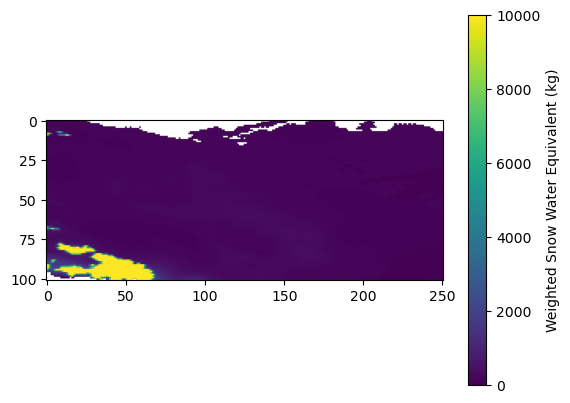

In [177]:

plt.imshow(xda[100,:,:], cmap="viridis")
plt.colorbar(label="Weighted Snow Water Equivalent (kg)")

In [180]:
# Aggregate xda by day
xda_daily = xda.sortby("time").resample(time="1D").mean()

# Function to update the plot based on the selected time index
def plot_data(time_index):
    plt.figure(figsize=(10, 6))
    plt.contourf(xda_daily.longitude, xda_daily.latitude, xda_daily[time_index, :, :], cmap="coolwarm")
    plt.colorbar(label="Snowfall")
    plt.title(f"Snowfall at Time {xda_daily.time[time_index].values}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Create an interactive slider
interact(plot_data, time_index=IntSlider(min=0, max=xda_daily.shape[0]-1, step=1, value=0, continuous_update=True, layout={'width': '800px'}))


interactive(children=(IntSlider(value=0, description='time_index', layout=Layout(width='800px'), max=8673), Ou…

<function __main__.plot_data(time_index)>

In [3]:
from sqlalchemy import create_engine, text
import pandas as pd
import geopandas as gdf

# Append the pyquacache path
sys.path.append(str(Path().resolve().parent))
import pyquacache.utils.queries as pqc
from pyquacache.defs.config import db_url_prod as db_url

# Download drainage basin boundaries
gdf = pqc.fetch_drainage_basin_boundaries()


In [161]:
# get SWE metadata
param_name = "snow water equivalent"
params = pqc.fetch_parameters(db_url)
param_md = params.loc[params["param_name"] == param_name, :]
param_md["unit_default"].values[0]



# get location IDs for SWE timeseries
engine = create_engine(db_url)
with engine.connect() as connection:
    out = connection.execute(
        text(f"SELECT * FROM continuous.timeseries WHERE parameter_id = {param_md.index[0]}")
    )

timeseries_df = pd.DataFrame(out).set_index("timeseries_id")
loc_ids = timeseries_df["location_id"]

# get locations at geodataframe
locations = pqc.fetch_locations(db_url).loc[loc_ids,:]

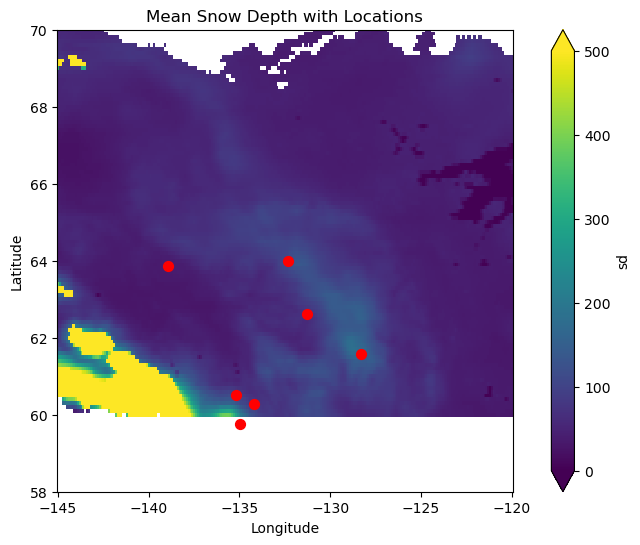

In [298]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot xda
xda.mean(dim="time").plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
locations.plot(ax=ax, color='red', label='Locations', markersize=50)

# Add title and labels
ax.set_title("Mean Snow Depth with Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_ylim(58, 70)
plt.show()




In [163]:
# download all contniuous SWE measurements
ts_ids = timeseries_df.index.tolist()
res = {}

def fetch_timeseries_corrected(ts_id, db_url=db_url):
    with engine.connect() as connection:
        out = connection.execute(
            text("SELECT * FROM continuous.measurements_continuous_corrected WHERE timeseries_id IN ({})".format(ts_id))
        )

        timeseries_md = connection.execute(
            text("SELECT * FROM continuous.timeseries WHERE timeseries_id IN ({})".format(ts_id))
        )
        timeseries_md = pd.DataFrame(timeseries_md).squeeze().to_dict()

        parameter_md = connection.execute(
            text("SELECT * FROM public.parameters WHERE parameter_id IN ({})".format(timeseries_md["parameter_id"]))
        )
        parameter_md = pd.DataFrame(parameter_md).squeeze().to_dict()

        out = pd.DataFrame(out).set_index("datetime")["value_corrected"]
        units = parameter_md["unit_default"]
        param = parameter_md["param_name"]
        tag = f"{ts_id}_{param}({units})"
        out.name = tag
        out = out.astype(float)
        out.to_frame()
        
        metadata = {"timeseries": timeseries_md, "parameter": parameter_md}
        return out, metadata

In [166]:
yg_ts.index

DatetimeIndex(['2022-09-21 00:00:00+00:00', '2022-09-22 00:00:00+00:00',
               '2022-09-23 00:00:00+00:00', '2022-09-24 00:00:00+00:00',
               '2022-09-25 00:00:00+00:00', '2022-09-26 00:00:00+00:00',
               '2022-09-27 00:00:00+00:00', '2022-09-28 00:00:00+00:00',
               '2022-09-29 00:00:00+00:00', '2022-09-30 00:00:00+00:00',
               ...
               '2025-03-25 00:00:00+00:00', '2025-03-26 00:00:00+00:00',
               '2025-03-27 00:00:00+00:00', '2025-03-28 00:00:00+00:00',
               '2025-03-29 00:00:00+00:00', '2025-03-30 00:00:00+00:00',
               '2025-03-31 00:00:00+00:00', '2025-04-01 00:00:00+00:00',
               '2025-04-02 00:00:00+00:00', '2025-04-03 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=926, freq='D')

In [182]:
results = {}

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    x, y = locations.loc[loc_id, "geometry"].x, locations.loc[loc_id, "geometry"].y

    era5_ts = xda.sel(longitude=x, latitude=y, method="nearest").to_dataframe().reset_index()
    era5_ts = era5_ts.set_index('time')['sd']

    yg_ts, _ = fetch_timeseries_corrected(ts_id)

    # aggregate to daily before syncing
    yg_ts = yg_ts.resample('D').mean()
    era5_ts = era5_ts.resample('D').mean()

    synced_ts = pd.concat([era5_ts, yg_ts], axis=1, join="outer")
    synced_ts.columns = ["ERA5", "YG"]

    results[ts_id] = synced_ts


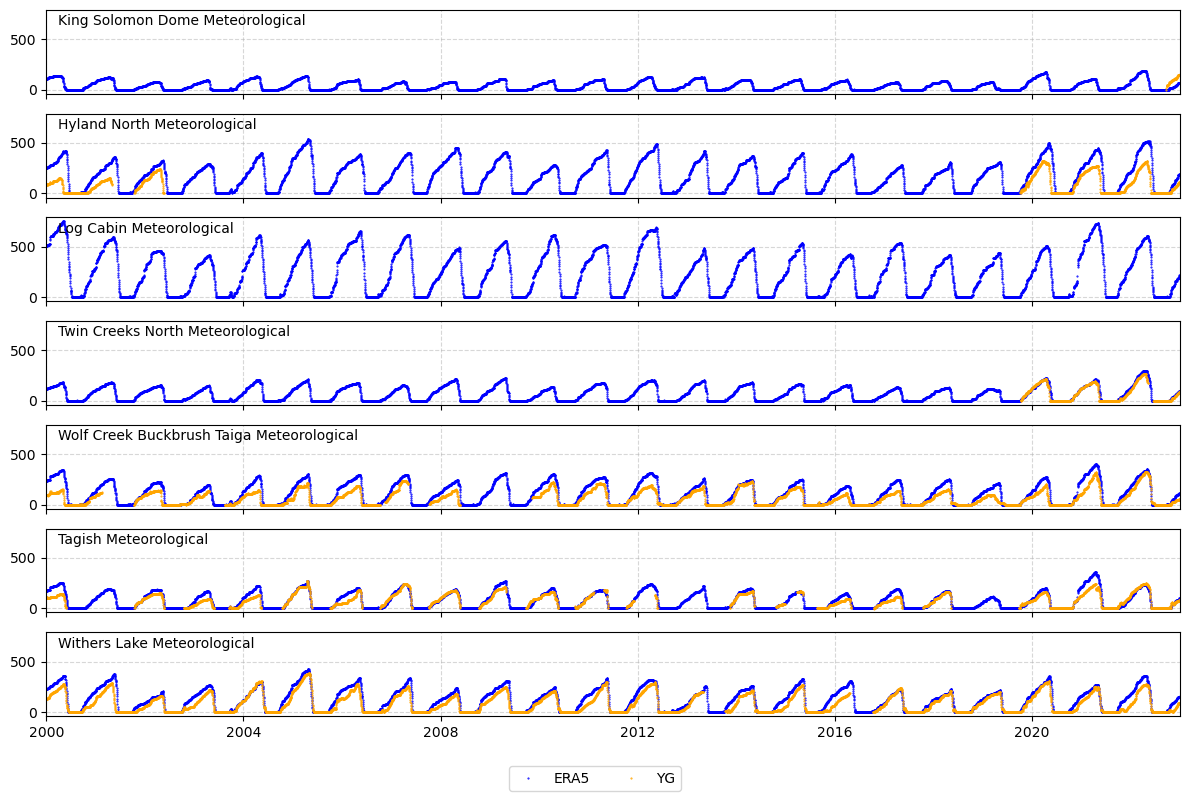

In [184]:
fig, axes = plt.subplots(7, 1, figsize=(12, 8), sharex=True, sharey=True)

axes = axes.flatten()  # Flatten the axes array for easier indexing


for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    ax = axes[i]
    synced_ts = results[ts_id]
    ax.plot(synced_ts.index, synced_ts["ERA5"], label="ERA5", color="blue", marker='.', markersize=1, linestyle='', linewidth=0.5)
    ax.plot(synced_ts.index, synced_ts["YG"], label="YG", color="orange", marker='.', markersize=1, linestyle='', linewidth=0.5)

    # Add location annotation
    ax.text(0.01, 0.95, loc_name, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')

    ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2023-01-01"))
    ax.grid(True, linestyle='--', alpha=0.5)

# Add a single legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for the legend
plt.show()

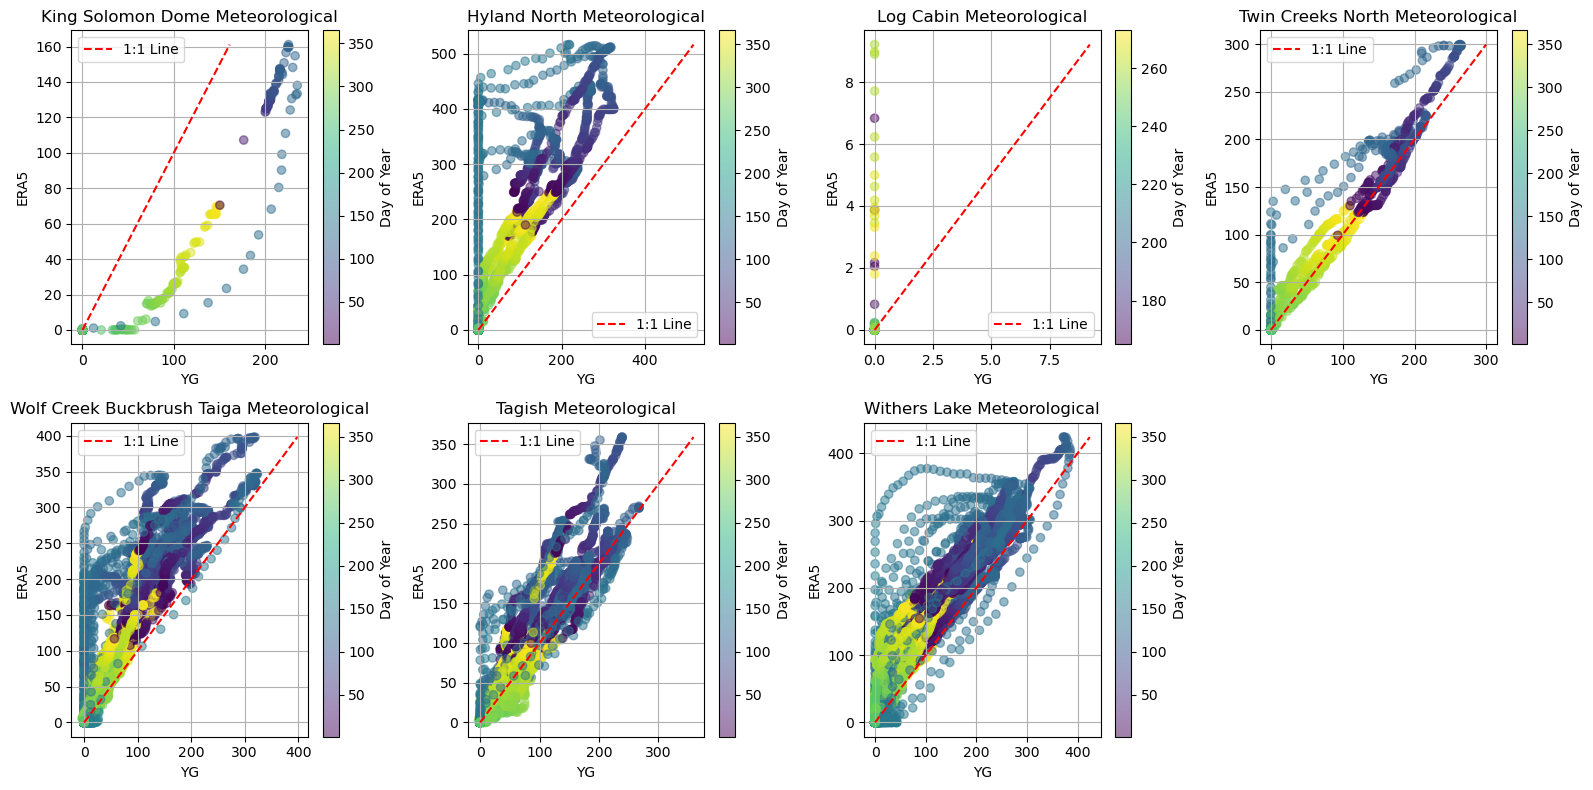

In [185]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for ax, (ts_id, data) in zip(axes, results.items()):
    # Drop NaN values for clean comparison
    data = data.dropna()

    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    # Plot 1:1 scatter plot
    scatter = ax.scatter(data["YG"], data["ERA5"], c=data.index.dayofyear, cmap="viridis", alpha=0.5)
    plt.colorbar(scatter, ax=ax, label="Day of Year")
    
    ax.plot([data["ERA5"].min(), data["ERA5"].max()], [data["ERA5"].min(), data["ERA5"].max()], color="red", linestyle="--", label="1:1 Line")

    # Set labels and title
    ax.set_xlabel("YG")
    ax.set_ylabel("ERA5")
    ax.set_title(f"{loc_name}")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

import geopandas as gpd

locations_table = pqc.fetch_locations()

results_table = pqc.fetch_table(table_name="discrete.results").set_index("result_id")

results_table = results_table.loc[results_table["parameter_id"] == 21]

sample_ids = results_table.sample_id.unique()
samples_table = pqc.fetch_table(table_name="discrete.samples").set_index("sample_id")
results_table["location_id"] = samples_table.loc[results_table["sample_id"].values, "location_id"].values

results_table["datetime"] = samples_table.loc[results_table["sample_id"].values, "datetime"].values
results_table["datetime"] = results_table["datetime"].dt.tz_localize("UTC")
results_table["geometry"] = locations_table.loc[results_table["location_id"].values, "geometry"].values
results_table = gpd.GeoDataFrame(results_table)

In [251]:
engine = create_engine(db_url)
with engine.connect() as connection:
    table_result = connection.execute(
        text(f"SELECT * FROM public.datum_conversions WHERE current = TRUE")
    )
datums_table = pd.DataFrame(table_result)

results_table["datum"] = datums_table.set_index("location_id").loc[results_table["location_id"].values, "conversion_m"].values
results_table["datum"] = results_table["datum"].astype(float)

In [318]:
results_table["era5_result"] = np.nan

for name, row in tqdm(results_table.iloc[:,:].iterrows()):
    x, y = row.geometry.x, row.geometry.y
    dt = row.datetime

    # Even though ERA5 is UTC, the selection result is not localized in UTC
    res = xda.sel(longitude=x, latitude=y, time = dt, method="nearest")
    
    time_diff = dt - pd.Timestamp(res.time.values).tz_localize("UTC")
    time_diff = np.absolute(time_diff.days)

    if time_diff < 3:
        results_table.loc[name, "era5_result"] = res.values
    else:
        results_table.loc[name, "era5_result"] = np.nan


# Calculate the error (difference between observed and ERA5 results)
results_table["error"] = results_table["result"] - results_table["era5_result"]



4186it [00:09, 429.12it/s]


KeyError: "['error'] not in index"

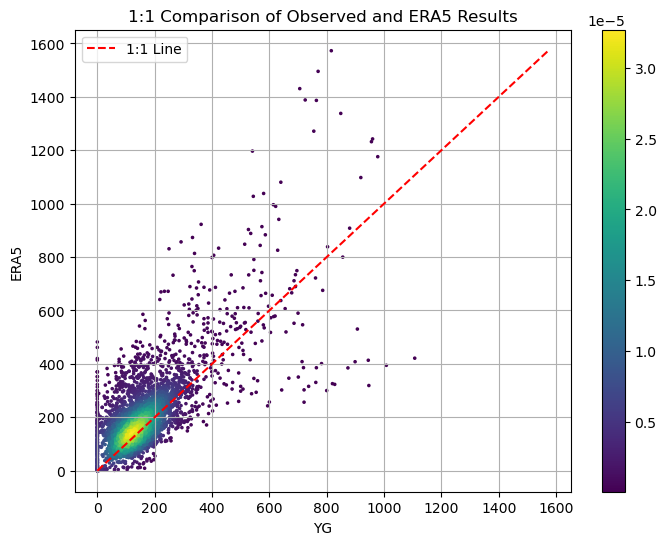

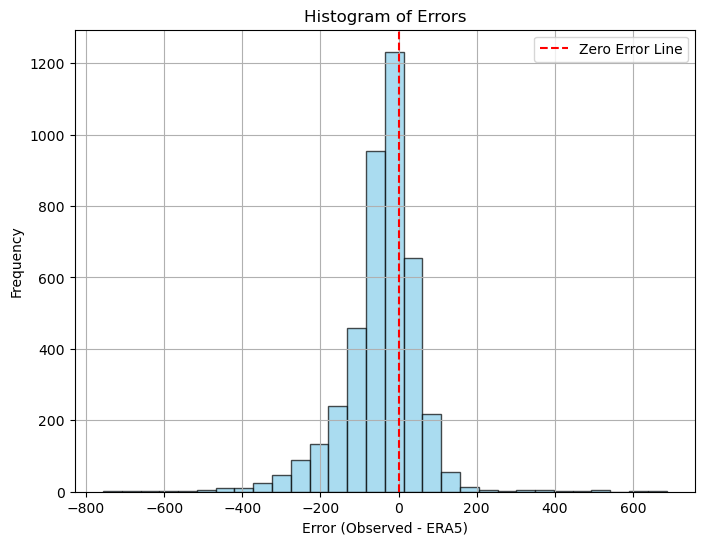

In [285]:
from scipy.stats import gaussian_kde

# Drop rows with NaN values in either 'result' or 'era5_result'
results_table = results_table.dropna(subset=["result", "era5_result"])
results_table["result"] = results_table["result"].astype(float)
results_table["era5_result"] = results_table["era5_result"].astype(float)
# Extract day of year from the datetime column
results_table["day_of_year"] = results_table["datetime"].dt.dayofyear

# Create the 1:1 scatter plot
plt.figure(figsize=(8, 6))


# Scatter plot with colorized markers based on day of year
# Calculate the point density
xy = np.vstack([results_table["result"], results_table["era5_result"]])
z = gaussian_kde(xy)(xy)

# Scatter plot with colorized markers based on density
scatter = plt.scatter(
    results_table["result"],
    results_table["era5_result"],
    c=z,
    cmap="viridis",
    marker='.',
    s=10  # Marker size
)


# Add a colorbar
cbar = plt.colorbar(scatter)

# Add a 1:1 line
min_val = min(results_table["result"].min(), results_table["era5_result"].min())
max_val = max(results_table["result"].max(), results_table["era5_result"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="1:1 Line")

# Set plot labels and title
plt.xlabel("YG")
plt.ylabel("ERA5")
plt.title("1:1 Comparison of Observed and ERA5 Results")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Plot the histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(results_table["error"], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")

# Set plot labels and title
plt.xlabel("Error (Observed - ERA5)")
plt.ylabel("Frequency")
plt.title("Histogram of Errors")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

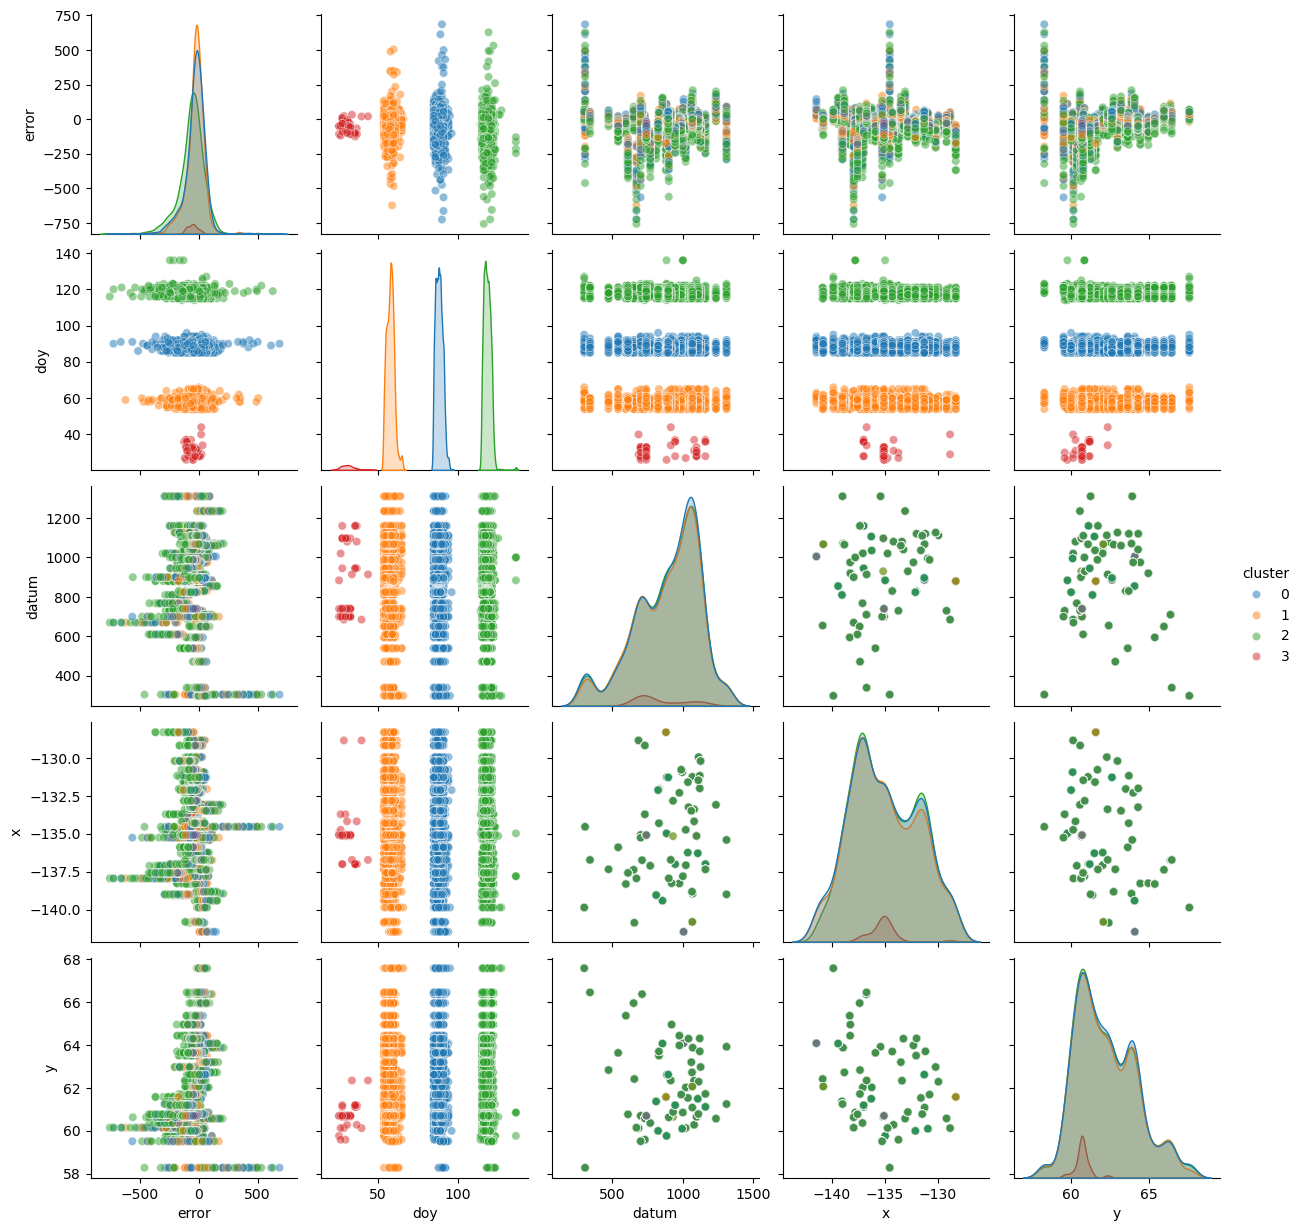

In [292]:
import seaborn as sns
from sklearn.cluster import KMeans
results_table["x"] = results_table.geometry.x
results_table["y"] = results_table.geometry.y
results_table["doy"] = results_table.datetime.dt.dayofyear

# Select numeric columns for the scatterplot matrix
include_columns = ["error","doy","datum","x","y"]

# Perform KMeans clustering on the 'doy' column
kmeans = KMeans(n_clusters=4, random_state=42)
results_table['cluster'] = kmeans.fit_predict(results_table[['doy']])

# Create a scatterplot matrix with hue set to the cluster
sns.pairplot(results_table[include_columns + ['cluster']], diag_kind='kde', hue='cluster', plot_kws={'alpha': 0.5}, palette="tab10")

# Show the plot
plt.show()


In [272]:
results_table.location_id.unique()

array([ 46,  47, 158,  57, 125, 146,  44,  77,  96, 130, 136, 137, 142,
       166, 110,  54,  20, 100,  45, 101,  66, 160, 170, 177, 178,  86,
       102, 114, 159,  41,  87, 155, 118,  33,  21,  34,  53, 150, 151,
       104, 116, 119, 122, 182,  88,  93,  35,  78, 123,  94, 127,  67,
        89, 161,  69, 148, 126, 111,  42,  22,  79,  23, 317, 319],
      dtype=int64)

In [302]:
day = pd.Timestamp("2020-03-01").tz_localize("UTC")

idx = np.abs((results_table["datetime"] - day).dt.days) < 7
df = results_table.loc[idx,:]




In [322]:
df["error"]

result_id
369      -23.697571
777     -135.123154
1251     -31.788101
1727     -71.191330
2143     -16.907318
2351      53.123520
2699     -31.244873
3051      14.926361
3363     -30.105881
3681      90.691132
4083      42.380203
4431      71.201782
4787      61.445770
5141     -10.967590
5493     -22.337608
5955     -22.137238
6303    -119.802170
6655     -22.202011
6999    -159.041748
7399     -14.444214
7747      51.457932
8091     -17.025085
8441     -75.897797
8783     -60.675690
9119     -15.738541
9593       1.344925
9939    -100.844177
10267     27.270058
10593    -54.484528
10841    340.682373
11179     -4.667358
11873    -33.765778
12487   -248.393585
12795    -85.271912
13329     -8.493195
13591    -26.493195
14023     26.044037
14399      0.134216
14641    -31.788895
14889     -7.233765
15133   -107.802856
15561    -45.016998
15793    -13.812469
16037     34.540070
16755    -43.832687
16993     31.403259
17227    -82.743790
17465      9.581833
17701    -12.907318
17871    -

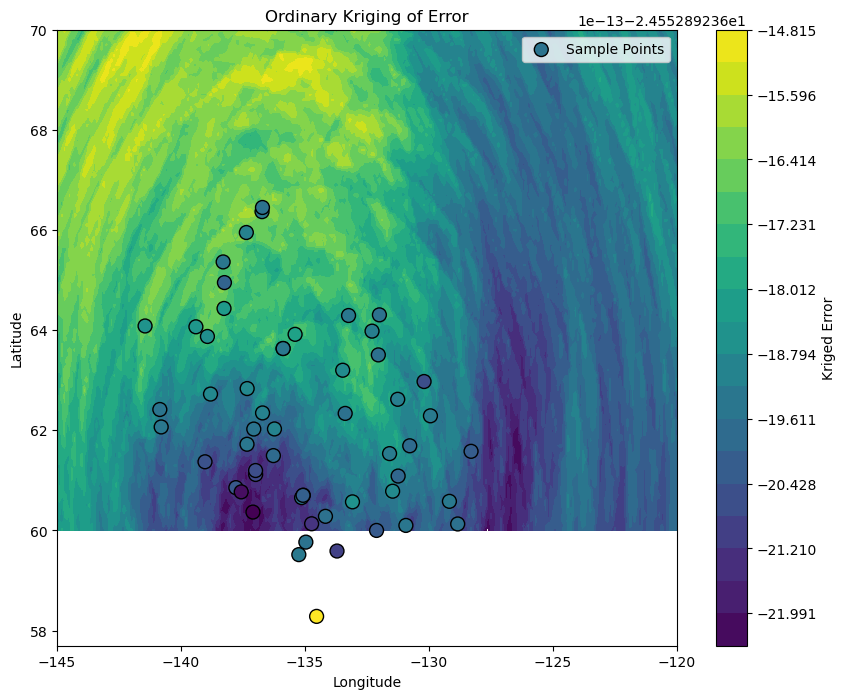

In [321]:
from pykrige.ok import OrdinaryKriging

# Extract coordinates and the error values
x_coords = df["x"].values
y_coords = df["y"].values
errors = df["error"].values

# Perform ordinary kriging
OK = OrdinaryKriging(
    x_coords, y_coords, errors,
    variogram_model="linear",  # You can also try 'spherical', 'exponential', etc.
    verbose=False,
    enable_plotting=False
)

# Define a grid for interpolation
grid_x = xda.longitude.values
grid_y = xda.latitude.values

grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Interpolate the error values on the grid
z, ss = OK.execute("grid", grid_x, grid_y)

# Plot the kriging result
plt.figure(figsize=(10, 8))
plt.contourf(grid_xx, grid_yy, z, cmap="viridis", levels=20)
plt.colorbar(label="Kriged Error")
plt.scatter(x_coords, y_coords, c=errors, cmap="viridis", edgecolor="k", label="Sample Points", s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ordinary Kriging of Error")
plt.legend()
plt.show()

<xarray.DataArray 'sd' (latitude: 101, longitude: 251)> Size: 101kB
array([[69.08131 , 67.976   , 67.50107 , ...,       nan,       nan,
              nan],
       [62.577248, 63.74836 , 63.732147, ...,       nan,       nan,
              nan],
       [62.343597, 63.074112, 64.64481 , ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 89.40983 , 88.31024 ,
        87.65316 ],
       [      nan,       nan,       nan, ..., 88.085175, 86.49635 ,
        85.78873 ],
       [      nan,       nan,       nan, ..., 86.66611 , 85.392   ,
        84.19895 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 808B 70.0 69.9 69.8 69.7 ... 60.2 60.1 60.0
  * longitude  (longitude) float64 2kB -145.0 -144.9 -144.8 ... -120.1 -120.0
    time       datetime64[ns] 8B 2020-03-01
Attributes:
    units:    mm

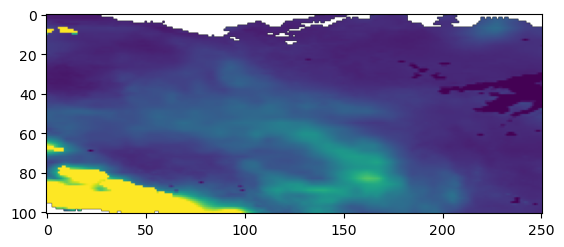

In [314]:
plt.imshow(xda.sel(time=day).values, vmin=0, vmax=500, cmap="viridis")


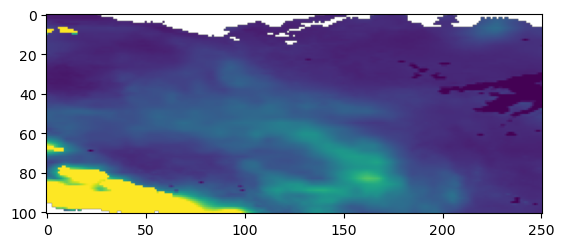

In [317]:
plt.imshow(xda.sel(time=day).values + z, vmin=0, vmax=500, cmap="viridis")

In [94]:
def poly_to_mask(data, poly):
    """
    Convert polygons to masks for a raster.
    """
    if isinstance(data, xr.DataArray):
        transform, shape = xda_to_transform(data)
    elif isinstance(data, Path):
        if data.suffix not in [".nc", ".tif", ".tiff"]:
            raise ValueError("Unsupported file format. Only NetCDF (.nc) and GeoTIFF (.tif/.tiff) are supported.")
        with rio.open(data) as src:
            transform = src.transform
            shape = src.shape
    else:
        raise ValueError("Unsupported data type. Must be an xarray.DataArray or a file path.")

    # Create masks for each polygon in the GeoDataFrame
    masks = {}
    for key, geom in poly["geometry"].items():
        masks[key] = geometry_mask([geom], transform=transform, invert=True, all_touched=False, out_shape=shape)

    return masks
# Generate masks
xda_upsampled = pqc.upsample_xda(xda, factor=4)
masks = poly_to_mask(data=xda_upsampled, poly=gdf)


: 

: 

<Axes: >

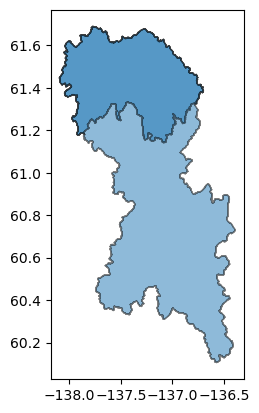

In [ ]:
gdf.iloc[:2].plot(facecolor=None, edgecolor="black", alpha=0.5)

C:\Users\esniede\AppData\Local\Temp\ipykernel_19592\2803845405.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


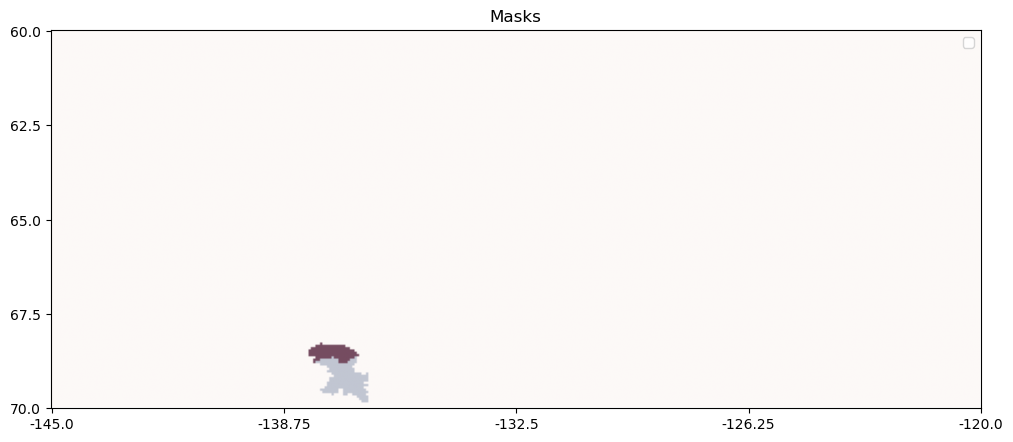

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, color in zip(range(0, 2), ['Blues', 'Reds', 'Greens']):
    ax.imshow(masks[list(masks.keys())[i]], cmap=color, alpha=0.5, label=f"Mask {i}")
ax.set_xticks(np.linspace(0, masks[list(masks.keys())[0]].shape[1], 5))
ax.set_xticklabels(np.linspace(xda.longitude.min().item(), xda.longitude.max().item(), 5).round(2))
ax.set_yticks(np.linspace(0, masks[list(masks.keys())[0]].shape[0], 5))
ax.set_yticklabels(np.linspace(xda.latitude.min().item(), xda.latitude.max().item(), 5).round(2))
ax.set_title("Masks")
ax.legend()
plt.show()